In [132]:
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import zuko
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from scripts.utils import sinkhorn, MMDLoss, RBF

def simple_mmd(X, Y):
    Z = torch.vstack([X, Y])
    L2_distances = torch.cdist(Z, Z) ** 2
    K = torch.exp(-0.5 * L2_distances)
    X_size = X.shape[0]
    XX = K[:X_size, :X_size].mean()
    XY = K[:X_size, X_size:].mean()
    YY = K[X_size:, X_size:].mean()
    return XX - 2 * XY + YY

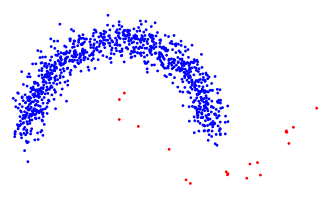

In [73]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = torch.cat(
        [
            torch.pi * torch.rand(n),
            torch.pi * torch.rand(n // 50) + torch.pi,
        ]
    )
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(1000)

plt.figure(figsize=(4, 4))
plt.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
plt.savefig("images/two_moons.png", dpi=300)

In [74]:
nominal = samples[labels == 0]
failure = samples[labels == 1]
failure.shape

torch.Size([20, 2])

100%|██████████| 200/200 [00:01<00:00, 107.32it/s]


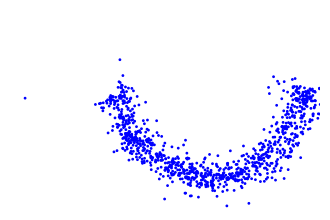

In [113]:
# Train a model to evaluate against with lots of data
eval_samples, eval_labels = two_moons(20000)
eval_samples = eval_samples[eval_labels == 1]
flow_failure_eval = zuko.flows.NSF(features=2, hidden_features=(64, 64))
failure_optimizer = torch.optim.Adam(flow_failure_eval.parameters(), lr=1e-3)

pbar = tqdm(range(200))
for epoch in pbar:
    failure_optimizer.zero_grad()

    loss_failure = -flow_failure_eval().log_prob(eval_samples).mean()
    loss_failure.backward()
    failure_optimizer.step()

_, ax = plt.subplots(1, 1, figsize=(4, 4))
failure_samples = flow_failure_eval().sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)
ax.scatter(*failure_samples.T, s=1, c=failure_labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
# plt.savefig('images/two_moo

In [75]:
# Train single NSF with KL regularization
beta = 0.01
flow_nsf_beta_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_failure = zuko.flows.NSF(features=2, hidden_features=(64, 64))
nominal_optimizer = torch.optim.Adam(flow_nsf_beta_nominal.parameters(), lr=1e-3)
failure_optimizer = torch.optim.Adam(flow_nsf_beta_failure.parameters(), lr=1e-3)

pbar = tqdm(range(200))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    failure_optimizer.zero_grad()

    loss_nominal = -flow_nsf_beta_nominal().log_prob(nominal).mean()

    loss_nominal.backward()
    nominal_optimizer.step()

    p_dist = flow_nsf_beta_failure()
    q_dist = flow_nsf_beta_nominal()
    p_samples, p_logprobs = p_dist.rsample_and_log_prob((100,))
    q_logprobs = q_dist.log_prob(p_samples)
    kl_divergence = (p_logprobs - q_logprobs).mean(dim=0)

    loss_failure = (
        -flow_nsf_beta_failure().log_prob(failure).mean() + beta * kl_divergence
    )
    loss_failure.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {loss_nominal.detach().item():.3f}, {loss_failure.detach().item():.3f}"
    )

(0) 2.304, 3.802:   0%|          | 0/200 [00:00<?, ?it/s]

(199) 0.287, -1.523: 100%|██████████| 200/200 [00:09<00:00, 21.35it/s]


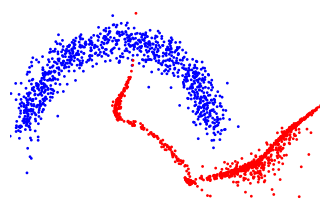

In [76]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
nominal_samples = flow_nsf_beta_nominal().sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_failure().sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)
samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
# plt.savefig('images/two_moons_nsf_context_beta.png', dpi=300)

In [103]:
# Train calibrated NSF
beta = 1.0
n_permutations = 5
permutation_size = int(0.5 * failure.shape[0])
flow_nsf_beta_calibrated_nominal = zuko.flows.NSF(features=2, hidden_features=(64, 64))
flow_nsf_beta_calibrated_failure = zuko.flows.NSF(
    features=2, context=n_permutations, hidden_features=(64, 64)
)

nominal_optimizer = torch.optim.Adam(
    flow_nsf_beta_calibrated_nominal.parameters(), lr=1e-3
)
failure_optimizer = torch.optim.Adam(
    flow_nsf_beta_calibrated_failure.transform.parameters(), lr=1e-3
)

# Create a set of permuted failure samples
failure_permutations = []
for i in range(n_permutations):
    failure_permutations.append(torch.randperm(failure.shape[0])[:permutation_size])

pbar = tqdm(range(500))
for epoch in pbar:
    nominal_optimizer.zero_grad()
    loss_nominal = -flow_nsf_beta_calibrated_nominal().log_prob(nominal).mean()
    loss_nominal.backward()
    nominal_optimizer.step()

    failure_optimizer.zero_grad()
    total_failure_loss = torch.tensor(0.0)

    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = 1.0
        total_failure_loss += (
            -flow_nsf_beta_calibrated_failure(label)
            .log_prob(failure[failure_permutations[i]])
            .mean()
            / n_permutations
        )

    # Sample some random labels
    n_random_labels = 100
    random_labels = torch.rand(n_random_labels, n_permutations)
    random_labels = torch.vstack((random_labels, torch.ones(1, n_permutations)))
    samples = flow_nsf_beta_calibrated_failure(random_labels).rsample((100,))
    kl_p_base = (
        flow_nsf_beta_calibrated_failure(random_labels).log_prob(samples)
        - flow_nsf_beta_calibrated_failure.base(random_labels).log_prob(samples)
    ).mean(dim=0)
    max_kl = torch.maximum(torch.tensor(1.0), kl_p_base[-1].detach())
    kl_err = kl_p_base/max_kl - torch.norm(random_labels, dim=-1) / n_permutations
    total_failure_loss += beta * (kl_err ** 2).mean()

    # Also try to reconstruct the nominal with a zero label
    label = torch.zeros(n_permutations)
    total_failure_loss += (
        -flow_nsf_beta_calibrated_failure(label).log_prob(nominal).mean()
        # / n_permutations
    )

    total_failure_loss.backward()
    failure_optimizer.step()

    pbar.set_description(
        f"({epoch}) {loss_nominal.detach().item():.3f}, {total_failure_loss:.3f} (max kl: {max_kl:.3f})"
    )

  0%|          | 0/500 [00:00<?, ?it/s]

(361) 0.270, -1.738 (max kl: 1.000):  72%|███████▏  | 362/500 [01:03<00:24,  5.72it/s]


KeyboardInterrupt: 

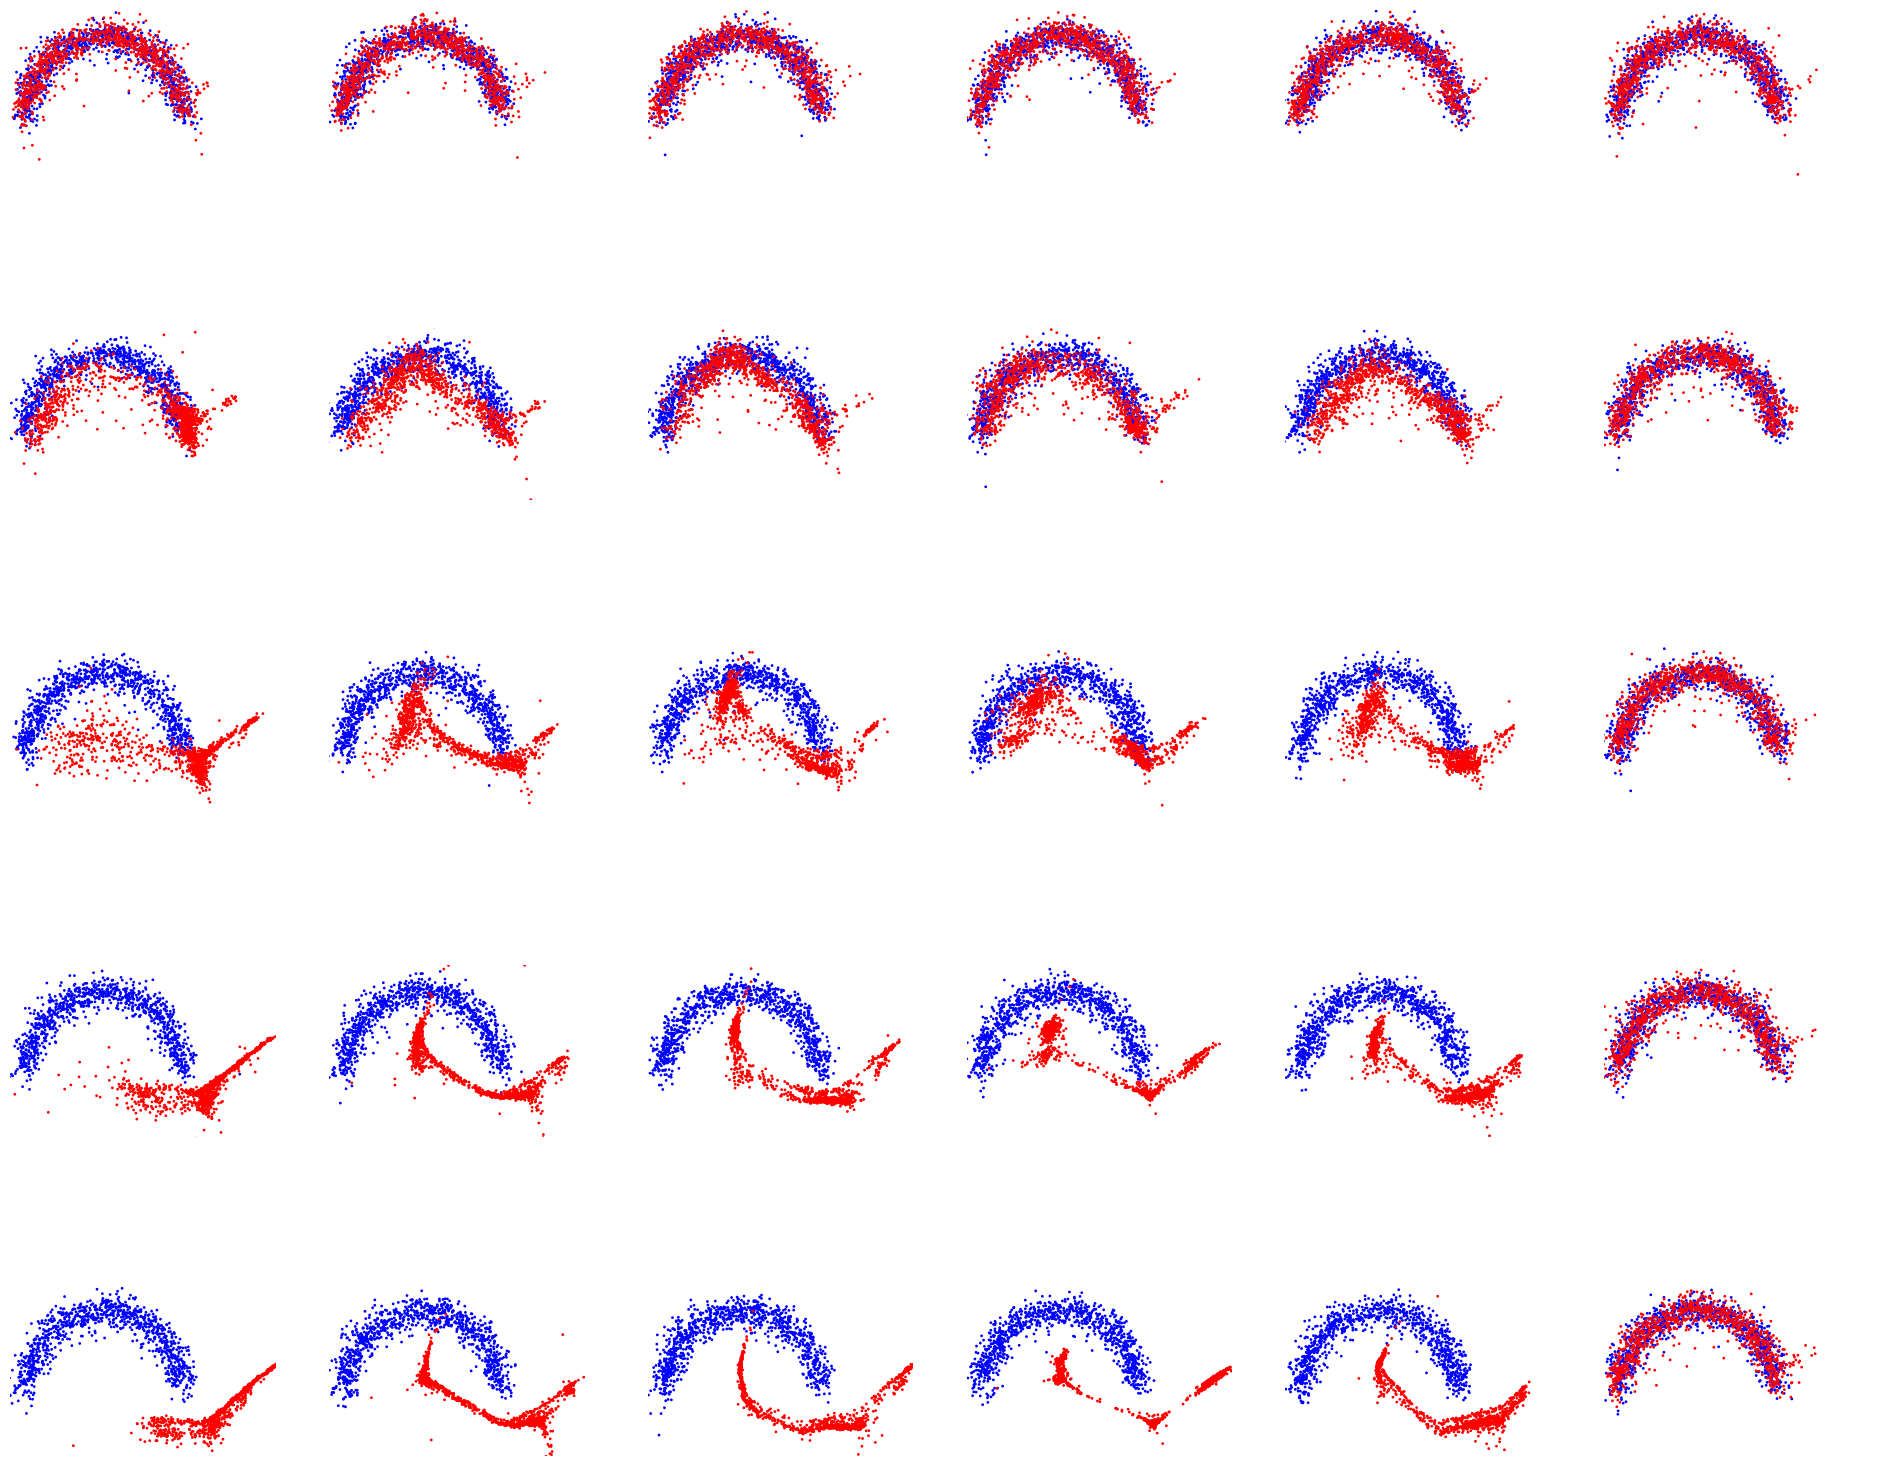

In [106]:
n_steps = 5
_, axs = plt.subplots(n_steps, 1 + n_permutations, figsize=(4 * (1 + n_permutations), 4 * n_steps))
for row, j in enumerate(torch.linspace(0, 1, n_steps)):
    for i in range(n_permutations):
        label = torch.zeros(n_permutations)
        label[i] = j

        nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
        nominal_labels = torch.tensor([0.0]).expand(1_000)
        failure_samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
        failure_labels = torch.tensor([1.0]).expand(1_000)

        samples = torch.cat((nominal_samples, failure_samples), axis=0)
        labels = torch.cat((nominal_labels, failure_labels), axis=0)
        axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
        # Turn off axis ticks
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])
        axs[row, i].axis("off")
        axs[row, i].set_ylim([-1.1, 1.1])
        axs[row, i].set_xlim([-1.7, 1.7])
        # Equal aspect
        axs[row, i].set_aspect("equal")
        # plt.savefig('images/two_moons_cnf_stacked.png', dpi=300)

    i = -1
    label = torch.zeros(n_permutations)
    nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
    nominal_labels = torch.tensor([0.0]).expand(1_000)
    failure_samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
    failure_labels = torch.tensor([1.0]).expand(1_000)

    samples = torch.cat((nominal_samples, failure_samples), axis=0)
    labels = torch.cat((nominal_labels, failure_labels), axis=0)
    axs[row, i].scatter(*samples.T, s=1, c=labels, cmap="bwr")
    # Turn off axis ticks
    axs[row, i].set_xticks([])
    axs[row, i].set_yticks([])
    axs[row, i].axis("off")
    axs[row, i].set_ylim([-1.1, 1.1])
    axs[row, i].set_xlim([-1.7, 1.7])
    # Equal aspect
    axs[row, i].set_aspect("equal")

# plt.savefig('images/two_moons_cnf_calibrated_range.png', dpi=300)

In [109]:
# Calibration step: can we optimize the label to maximize performance on the full set?
label = torch.zeros(n_permutations, requires_grad=True)
label_optimizer = torch.optim.Adam([label], lr=1e-2)

pbar = tqdm(range(1000))
for epoch in pbar:
    label_optimizer.zero_grad()
    loss = -flow_nsf_beta_calibrated_failure(label).log_prob(failure).mean()
    loss.backward()
    label_optimizer.step()
    pbar.set_description(f"({epoch}) {loss.detach().item():.3f}")

print(label.detach())

(999) 0.738: 100%|██████████| 1000/1000 [00:08<00:00, 124.36it/s]

tensor([-0.1424,  0.6617,  0.3547, -0.2930,  0.9737])


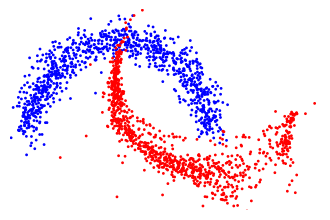

In [110]:
nominal_samples = flow_nsf_beta_calibrated_nominal().sample((1_000,))
nominal_labels = torch.tensor([0.0]).expand(1_000)
failure_samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
failure_labels = torch.tensor([1.0]).expand(1_000)

samples = torch.cat((nominal_samples, failure_samples), axis=0)
labels = torch.cat((nominal_labels, failure_labels), axis=0)

_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(*samples.T, s=1, c=labels, cmap="bwr")
# Turn off axis ticks
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim([-1.1, 1.1])
plt.xlim([-1.7, 1.7])
# Equal aspect
plt.gca().set_aspect("equal")
# plt.savefig('images/two_moons_nsf_calibrated.png', dpi=300)

Sinkhorn:
	Uncalibrated/Eval: 0.5445895748798693
	Calibrated/Eval: 0.6949004945918092
MMD (0.01):
	Uncalibrated/Eval Sink: 0.05017334222793579
	Calibrated/Eval Sink: 0.04956364631652832
MMD (0.1):
	Uncalibrated/Eval Sink: 0.05017334222793579
	Calibrated/Eval Sink: 0.04956364631652832
MMD (1.0):
	Uncalibrated/Eval Sink: 0.05017334222793579
	Calibrated/Eval Sink: 0.04956364631652832
MMD (10.0):
	Uncalibrated/Eval Sink: 0.05017334222793579
	Calibrated/Eval Sink: 0.04956364631652832
MMD simple:
	Uncalibrated/Eval: 0.03773212432861328
	Calibrated/Eval: 0.04572033882141113
KL(eval || p):
	Uncalibrated: 4.0703630447387695
	Calibrated: 0.8767860531806946
KL(p || eval):
	Uncalibrated: 1.59712553024292
	Calibrated: 1.3846911191940308
H(eval || p):
	Uncalibrated: 4.553598403930664
	Calibrated: 1.3600212335586548


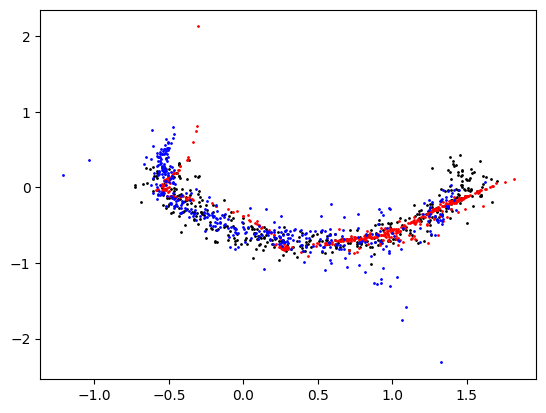

In [145]:
eval_samples, eval_labels = two_moons(20000)
eval_samples = eval_samples[eval_labels == 1]

uncalibrated_samples = flow_nsf_beta_failure().sample((eval_samples.shape[0],))
calibrated_samples = flow_nsf_beta_calibrated_failure(label).sample((eval_samples.shape[0],))

plt.scatter(*eval_samples.T, s=1, c="k", label="True")
plt.scatter(*uncalibrated_samples.T, s=1, c="r", label="Uncalibrated")
plt.scatter(*calibrated_samples.T, s=1, c="b", label="Calibrated")

print("Sinkhorn:")
print(f"\tUncalibrated/Eval: {sinkhorn(uncalibrated_samples, eval_samples)}")
print(f"\tCalibrated/Eval: {sinkhorn(calibrated_samples, eval_samples)}")

for x in [0.01, 0.1, 1.0, 10.0]:
    loss = MMDLoss(RBF(n_kernels=1, mul_factor=x))
    print(f"MMD ({x}):")
    print(f"\tUncalibrated/Eval Sink: {loss(uncalibrated_samples, eval_samples)}")
    print(f"\tCalibrated/Eval Sink: {loss(calibrated_samples, eval_samples)}")

print("MMD simple:")
print(f"\tUncalibrated/Eval: {simple_mmd(uncalibrated_samples, eval_samples)}")
print(f"\tCalibrated/Eval: {simple_mmd(calibrated_samples, eval_samples)}")

samples = flow_failure_eval().sample((1_000,))
kl_eval_uncalibrated = (
    flow_failure_eval().log_prob(eval_samples)
    - flow_nsf_beta_failure().log_prob(eval_samples)
).mean()
kl_eval_calibrated = (
    flow_failure_eval().log_prob(eval_samples)
    - flow_nsf_beta_calibrated_failure(label).log_prob(eval_samples)
).mean()
print("KL(eval || p):")
print(f"\tUncalibrated: {kl_eval_uncalibrated}")
print(f"\tCalibrated: {kl_eval_calibrated}")

samples = flow_nsf_beta_failure().sample((1_000,))
kl_uncalibrated_eval = (
    flow_nsf_beta_failure().log_prob(samples)
    - flow_failure_eval().log_prob(samples)
).mean()
samples = flow_nsf_beta_calibrated_failure(label).sample((1_000,))
kl_calibrated_eval = (
    flow_nsf_beta_calibrated_failure(label).log_prob(samples)
    - flow_failure_eval().log_prob(samples)
).mean()
print("KL(p || eval):")
print(f"\tUncalibrated: {kl_uncalibrated_eval}")
print(f"\tCalibrated: {kl_calibrated_eval}")

ce_eval_uncalibrated = -(
    flow_nsf_beta_failure().log_prob(eval_samples)
).mean()
ce_eval_calibrated = -(
    flow_nsf_beta_calibrated_failure(label).log_prob(eval_samples)
).mean()
print("H(eval || p):")
print(f"\tUncalibrated: {ce_eval_uncalibrated}")
print(f"\tCalibrated: {ce_eval_calibrated}")

In [143]:
X = -calibrated_samples
Y = eval_samples
Z = torch.vstack([X, Y])
L2_distances = torch.cdist(Z, Z) ** 2
K = torch.exp(-0.5 * L2_distances)
X_size = X.shape[0]
XX = K[:X_size, :X_size].mean()
XY = K[:X_size, X_size:].mean()
YY = K[X_size:, X_size:].mean()
XX - 2 * XY + YY

tensor(0.3024)